Copyright 2020, Author: Yuanning Zheng, College Station, TX, 77840 <br>
All rights reserved. Please do not delete this copyright statement.	   		     			  	


In [0]:
!pip install pytorch_pretrained_bert

In [0]:
from pytorch_pretrained_bert.tokenization import BertTokenizer, WordpieceTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTraining, BertPreTrainedModel, BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification
from pathlib import Path
import torch
import re
from torch import Tensor
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from fastai.text import Tokenizer, Vocab
import pandas as pd
import fastai.layers as layers
import collections
import os
import pdb
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import csv
import pickle
#import evaluation
# if use GPU, the apex may need to be improted
# import apex
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from pytorch_pretrained_bert.optimization import BertAdam
import torch.nn.functional as F
from sklearn.metrics import matthews_corrcoef
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

In [0]:
# Go into your master directory
%cd /content/drive/My\ Drive/AirInvestor

/content/drive/My Drive/AirInvestor


In [0]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_PATH=Path('./data_cla')
DATA_PATH.mkdir(exist_ok=True)

TEST_DATA_Path = Path('./Mashvisor_data')

OUTPUT_DATA_PATH = Path('./output_cla')
OUTPUT_DATA_PATH.mkdir(exist_ok=True)

model_state_dict = None

BERT_PRETRAINED_PATH = Path('../BERT/uncased_L-12_H-768_A-12')

PYTORCH_PRETRAINED_BERT_CACHE = Path('./output_model_cla')
PYTORCH_PRETRAINED_BERT_CACHE.mkdir(exist_ok=True)


## Model Parameters

In [0]:
args = {
    "train_size": -1,                 # set to -1 if use whole dataset
    "val_size": -1,                   # set to -1 if use whole dataset
    "test_size" : -1,                  # set to -1 if use whole dataset
    "second_run" :False,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "airbnb descritpion predict",
    "bert_model": BERT_PRETRAINED_PATH,
    "finetuned_model": PYTORCH_PRETRAINED_BERT_CACHE/'finetuned_pytorch_model.bin/',
    "output_dir": OUTPUT_DATA_PATH,
    "max_seq_length": 300,
    "do_train": True,
    "do_eval": True,
    "do_test": True,
    "do_lower_case": True,
    "train_batch_size": 10,
    "eval_batch_size": 10,
    "learning_rate": 3e-5,
    "num_train_epochs": 4.0,
    "warmup_proportion": 0.1,
    "no_cuda": False,             # Set to False if use GPU
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,    # Set to False if use GPU
    "fp16": False,
    "loss_scale": 128
}


###  Model Class

In [0]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels=2):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        if labels is not None:

            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
             # loss_fct = MSELoss()
            # loss_fct = layers.MSELossFlat()
            # loss = loss_fct(logits.view(-1), labels.view(-1))
            
            return loss
        else:
            return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

## Data representation class

In [0]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [0]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

In [0]:
class MultiLabelTextProcessor(DataProcessor):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.labels = None
            
    def get_train_examples(self, data_dir, size=-1):
        filename = 'train.csv'
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, filename)))
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename))   
            return self._create_examples(data_df, "train")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename))

            return self._create_examples(data_df.sample(size), "train")
        
    def get_dev_examples(self, data_dir, size=-1):
        filename = "dev.csv"
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
            return self._create_examples(data_df, "dev")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename))

            return self._create_examples(data_df.sample(size), "dev")
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        data_df = pd.read_csv(os.path.join(data_dir, data_file_name))
        
        if size == -1:
            return self._create_examples(data_df, "test", labels_available=False)
        else:
            return self._create_examples(data_df.sample(size), "test", labels_available=False)

    def get_labels(self):
        """See base class."""
        if self.labels == None:
            self.labels = list(pd.read_csv(os.path.join(self.data_dir, "classes.txt"),header=None)[0].values)
        return self.labels

    def _create_examples(self, df, set_type, labels_available=True):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, row) in enumerate(df.values):
            #use id as guid
            guid = row[0]
            text_a = row[1]
            if labels_available:
                labels = row[2]
            else:
                labels = None
            examples.append(
                InputExample(guid=guid, text_a=text_a, labels=labels))
        return examples
        

In [0]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}
    num_labels = len(label_map)

    features = []
    for (ex_index, example) in enumerate(tqdm(examples)):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

                      
        if example.labels is not None:
          labels_ids = label_map[example.labels]
        else:
          labels_ids = None      
        
        if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features

In [0]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

## Metric functions

In [0]:
# Function to calculate the accuracy of our predictions vs labels 
# The input are logits and labels from each batch, logits is a 2D array, with each row is the logits of each label
# labels is a 1D array with all the true labels of the current batch
def flat_accuracy(logits, labels):
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Function to calculate the Matthews correlation coefficient
def MCC(logits, labels):
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = labels.flatten()
    atthews = matthews_corrcoef(pred_flat, labels_flat)
    return atthews

# Function to calculate R^2
def correlation(logits, labels):
  pred_flat = np.argmax(logits, axis=1).flatten()
  labels_flat = labels.flatten()
  r= np.corrcoef(pred_flat, labels_flat)[0,1]
# draw a scatter plot and save the figure to output directory
  print(len(labels_flat),len(pred_flat))
  print(labels_flat)
  print(pred_flat)
  plt.figure()
  plt.scatter(labels_flat, pred_flat)
  plt.ylabel('predicted value')
  plt.xlabel('True value')
  plt.savefig(OUTPUT_DATA_PATH/'evalutaion.png')
  return r**2

## Training warmup 

In [0]:
def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [0]:
processors = {
    "airbnb descritpion predict": MultiLabelTextProcessor
}

# Setup GPU parameters

if args["local_rank"] == -1 or args["no_cuda"]:
    device = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")
    n_gpu = torch.cuda.device_count()
#     n_gpu = 1
else:
    torch.cuda.set_device(args['local_rank'])
    device = torch.device("cuda", args['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args['local_rank'] != -1), args['fp16']))

04/19/2020 19:32:17 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False


In [0]:
args['train_batch_size'] = int(args['train_batch_size'] / args['gradient_accumulation_steps'])

In [0]:
random.seed(args['seed'])
#np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
if n_gpu > 0:
    torch.cuda.manual_seed_all(args['seed'])

In [0]:
task_name = args['task_name'].lower()

if task_name not in processors:
    raise ValueError("Task not found: %s" % (task_name))

In [0]:
processor = processors[task_name](args['data_dir'])
label_list = processor.get_labels()
num_labels = len(label_list)

In [0]:
label_list

[0, 1, 2, 3, 4, 5, 6]

In [0]:
num_labels

7

In [0]:
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

04/19/2020 19:32:17 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file ../BERT/uncased_L-12_H-768_A-12/vocab.txt


In [0]:
# Prepare model
def get_model():
#     pdb.set_trace()
    print(model_state_dict)
    
    # after train, load trained model (state_dict is the trained model)
    if model_state_dict:
        model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels, state_dict=model_state_dict)
   
    # before train, load pre-trained model
    else:
        model = BertForMultiLabelSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_labels)
    return model

model = get_model()

if args['fp16']:
    model.half()
model.to(device)
if args['local_rank'] != -1:
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    model = DDP(model)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

None


04/19/2020 19:32:17 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/19/2020 19:32:17 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpqvvlezt4
04/19/2020 19:32:22 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size

In [0]:
from torch.optim.lr_scheduler import _LRScheduler, Optimizer

class CyclicLR(object):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `batch_step` should be called after a batch has been used for training.
    To resume training, save `last_batch_iteration` and use it to instantiate `CycleLR`.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for eachparam groups.
            Default: 0.001
        max_lr (float or list): Upper boundaries in the cycle for
            each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function. Default: 0.006
        step_size (int): Number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch. Default: 2000
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        last_batch_iteration (int): The index of the last batch. Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         scheduler.batch_step()
        >>>         train_batch(...)
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

#         if not isinstance(optimizer, Optimizer):
#             raise TypeError('{} is not an Optimizer'.format(
#                 type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [0]:
# Eval Fn

def eval(eval_features, output_filename="eval_results.txt"):
    args['output_dir'].mkdir(exist_ok=True)


    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args['eval_batch_size'])
    
    all_logits = None
    all_labels = None
    
    model.eval()
    total_eval_loss, total_eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for step, batch in enumerate(tqdm(eval_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        if all_logits is None:
            all_logits = logits.detach().cpu().numpy()
        else:
            all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
            
        if all_labels is None:
            all_labels = label_ids.detach().cpu().numpy()
        else:    
            all_labels = np.concatenate((all_labels, label_ids.detach().cpu().numpy()), axis=0)
        
        # Accumulate the validation loss.
        total_eval_loss +=loss.item()
        
    # Report the final accuracy over all of the batches in this epoch.
    eval_accuracy = flat_accuracy(all_logits, all_labels)
          
    # Report the final accuracy over all of the batches in this epoch.
    #avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
    
    # Report the average loss over all of the batches in this epoch.
    avg_val_loss = total_eval_loss / len(eval_dataloader)
      
    # Report the Matthews correlation coefficient over all of the batches in this epoch.
    mcc = MCC(all_logits, all_labels)

    # Report the Pearson correlation coefficient over all of the batches in this epoch.
    R_square = correlation(all_logits, all_labels)
                  
    result = {'eval_loss': avg_val_loss,
              'eval_accuracy': eval_accuracy, 
              'mcc':mcc,
              'R_square': R_square 
              }    
    
    output_eval_file = os.path.join(args['output_dir'], output_filename)
    with open(output_eval_file, "a+") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))
    return avg_val_loss

### Load training and evaluation data

In [0]:
#Prepare train, dev examples
train_examples = None
eval_examples = None
num_train_steps = None

# if args['do_train']:
train_examples = processor.get_train_examples(args['full_data_dir'], size=args['train_size'])
num_train_steps = int(
    len(train_examples) / args['train_batch_size'] / args['gradient_accumulation_steps'] * args['num_train_epochs'])
    
#if args['do_eval']:
eval_examples = processor.get_dev_examples(args['full_data_dir'], size=args['val_size'])


04/19/2020 19:32:28 - INFO - __main__ -   LOOKING AT data_cla/train.csv


In [0]:
# only required to be invoked when running the script for the first time: convert train, dev examples to features and store the features

from tqdm.notebook import tqdm as tqdm

if not args['second_run']:
  train_features =  convert_examples_to_features(
      train_examples, label_list, args['max_seq_length'], tokenizer)
  with open(PYTORCH_PRETRAINED_BERT_CACHE/"train_features.pkl", "wb") as output:
      pickle.dump(train_features, output, pickle.HIGHEST_PROTOCOL)
  output.close()

if not args['second_run']:
  eval_features = convert_examples_to_features(
      eval_examples, label_list, args['max_seq_length'], tokenizer)
  with open(PYTORCH_PRETRAINED_BERT_CACHE/"eval_features.pkl", "wb") as output:
      pickle.dump(eval_features, output, pickle.HIGHEST_PROTOCOL)
  output.close()

In [0]:
# directly load the features 
with open(PYTORCH_PRETRAINED_BERT_CACHE/"train_features.pkl", "rb") as file:
    train_features = pickle.load(file)

with open(PYTORCH_PRETRAINED_BERT_CACHE/"eval_features.pkl", "rb") as file:
    eval_features = pickle.load(file)

In [0]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
t_total = num_train_steps
if args['local_rank'] != -1:
    t_total = t_total // torch.distributed.get_world_size()
if args['fp16']:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    optimizer = FusedAdam(optimizer_grouped_parameters,
                          lr=args['learning_rate'],
                          bias_correction=False,
                          max_grad_norm=1.0)
    if args['loss_scale'] == 0:
        optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
    else:
        optimizer = FP16_Optimizer(optimizer, static_loss_scale=args['loss_scale'])

else:
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=args['learning_rate'],
                         warmup=args['warmup_proportion'],
                         t_total=t_total)

scheduler = CyclicLR(optimizer, base_lr=2e-5, max_lr=5e-5, step_size=2500, last_batch_iteration=0)

### Train Model

In [0]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_examples))
logger.info("  Batch size = %d", args['train_batch_size'])
logger.info("  Num steps = %d", num_train_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)

labels = [f.label_ids for f in train_features]
all_label_ids = torch.tensor([f.label_ids for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
if args['local_rank'] == -1:
    train_sampler = RandomSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args['train_batch_size'])

04/19/2020 19:33:20 - INFO - __main__ -   ***** Running training *****
04/19/2020 19:33:20 - INFO - __main__ -     Num examples = 17442
04/19/2020 19:33:20 - INFO - __main__ -     Batch size = 10
04/19/2020 19:33:20 - INFO - __main__ -     Num steps = 6976


In [0]:
output_model_file = args["finetuned_model"]
# output_model_file = os.path.join(PYTORCH_PRETRAINED_BERT_CACHE, "finetuned_pytorch_model_for_AirBNB.bin")

def fit(num_epocs=args['num_train_epochs']):
    global_step = 0
    min_eval_loss = None
    
    model.train()
    
  # load evaluation dataset used for evaluation after each epoch    
    output_eval_file = os.path.join(args['output_dir'], "eval_results.txt")
    
  # overwrite existing file  
    f = open(output_eval_file, "w")
    f.close()

    #eval_examples = processor.get_dev_examples(args['full_data_dir'], size=args['val_size'])
   
    for i_ in tqdm(range(int(num_epocs)), desc="Epoch"):

        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):

            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            #print(loss)
            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                optimizer.backward(loss)
            else:
                loss.backward()

            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
    #             scheduler.batch_step()
                # modify learning rate with special warm up BERT uses
                lr_this_step = args['learning_rate'] * warmup_linear(global_step/t_total, args['warmup_proportion'])
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_this_step
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1
         
        logger.info('Train Loss after epoc {}: {}'.format(i_+1,tr_loss / nb_tr_steps))
        logger.info('Eval after epoc {}'.format(i_+1))
   
   #    write evaluation result into file

        with open(output_eval_file ,"a+") as f:
            f.write('Train Loss after epoc {}\n {}\n'.format(i_+1, tr_loss / nb_tr_steps))
            f.write('Eval after epoc {}\n'.format(i_+1))
        
        eval_loss = eval(eval_features)
    
    # Save/Update a trained model if the eval_loss is decreased than the saved one
        if min_eval_loss is None or eval_loss < min_eval_loss:
          model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
          torch.save(model_to_save.state_dict(), output_model_file) 
          min_eval_loss = eval_loss   
          logger.info('Saving model after epoc {}'.format(i_+1))
    

Next block is model training. Skip next block if model has been trained.

04/19/2020 19:45:59 - INFO - __main__ -   Train Loss after epoc 1: 1.718024335925422
04/19/2020 19:45:59 - INFO - __main__ -   Eval after epoc 1
04/19/2020 19:45:59 - INFO - __main__ -   ***** Running evaluation *****
04/19/2020 19:45:59 - INFO - __main__ -     Num examples = 1939
04/19/2020 19:45:59 - INFO - __main__ -     Batch size = 10


04/19/2020 19:46:45 - INFO - __main__ -   ***** Eval results *****
04/19/2020 19:46:45 - INFO - __main__ -     R_square = 0.4997375490160058
04/19/2020 19:46:45 - INFO - __main__ -     eval_accuracy = 0.36152656008251677
04/19/2020 19:46:45 - INFO - __main__ -     eval_loss = 1.525918510464049
04/19/2020 19:46:45 - INFO - __main__ -     mcc = 0.25849973968631207



1939 1939
[2 0 1 1 ... 3 1 4 6]
[2 1 0 2 ... 4 2 3 6]


04/19/2020 19:46:46 - INFO - __main__ -   Saving model after epoc 1


04/19/2020 19:59:13 - INFO - __main__ -   Train Loss after epoc 2: 1.3862326740193844
04/19/2020 19:59:13 - INFO - __main__ -   Eval after epoc 2
04/19/2020 19:59:13 - INFO - __main__ -   ***** Running evaluation *****
04/19/2020 19:59:13 - INFO - __main__ -     Num examples = 1939
04/19/2020 19:59:13 - INFO - __main__ -     Batch size = 10


04/19/2020 19:59:58 - INFO - __main__ -   ***** Eval results *****
04/19/2020 19:59:58 - INFO - __main__ -     R_square = 0.5444056791499606
04/19/2020 19:59:58 - INFO - __main__ -     eval_accuracy = 0.39865910263022175
04/19/2020 19:59:58 - INFO - __main__ -     eval_loss = 1.4591594614933447
04/19/2020 19:59:58 - INFO - __main__ -     mcc = 0.3014000573685409



1939 1939
[2 0 1 1 ... 3 1 4 6]
[4 0 0 2 ... 4 1 2 6]


04/19/2020 20:00:00 - INFO - __main__ -   Saving model after epoc 2


04/19/2020 20:12:28 - INFO - __main__ -   Train Loss after epoc 3: 0.9923221557393115
04/19/2020 20:12:28 - INFO - __main__ -   Eval after epoc 3
04/19/2020 20:12:28 - INFO - __main__ -   ***** Running evaluation *****
04/19/2020 20:12:28 - INFO - __main__ -     Num examples = 1939
04/19/2020 20:12:28 - INFO - __main__ -     Batch size = 10


04/19/2020 20:13:14 - INFO - __main__ -   ***** Eval results *****
04/19/2020 20:13:14 - INFO - __main__ -     R_square = 0.5268097446961734
04/19/2020 20:13:14 - INFO - __main__ -     eval_accuracy = 0.3888602372356885
04/19/2020 20:13:14 - INFO - __main__ -     eval_loss = 1.6146110686444746
04/19/2020 20:13:14 - INFO - __main__ -     mcc = 0.2869451720649627



1939 1939
[2 0 1 1 ... 3 1 4 6]
[3 1 0 3 ... 4 3 2 6]


04/19/2020 20:25:41 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
04/19/2020 20:25:42 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
04/19/2020 20:25:42 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
04/19/2020 20:25:42 - INFO - __main__ -   Train Loss after epoc 4: 0.6829026862167697
04/19/2020 20:25:42 - INFO - __main__ -   Eval after epoc 4
04/19/2020 20:25:42 - INFO - __main__ -   ***** Running evaluation *****
04/19/2020 20:25:42 - INFO - __main__ -     Num examples = 1939
04/19/2020 20:25:42 - INFO - __main__ -     Batch size = 10


04/19/2020 20:26:27 - INFO - __main__ -   ***** Eval results *****
04/19/2020 20:26:27 - INFO - __main__ -     R_square = 0.535205484449639
04/19/2020 20:26:27 - INFO - __main__ -     eval_accuracy = 0.39143888602372356
04/19/2020 20:26:27 - INFO - __main__ -     eval_loss = 1.7509324741117733
04/19/2020 20:26:27 - INFO - __main__ -     mcc = 0.2895027104305754



1939 1939
[2 0 1 1 ... 3 1 4 6]
[4 1 0 3 ... 4 3 2 6]



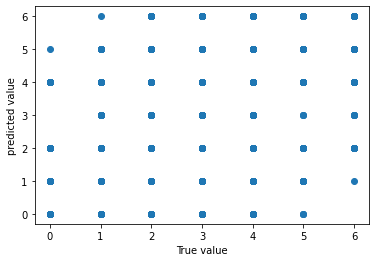

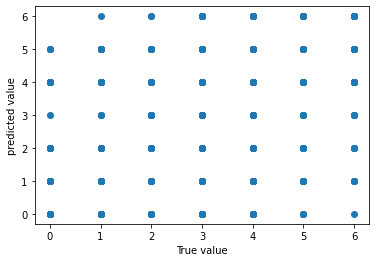

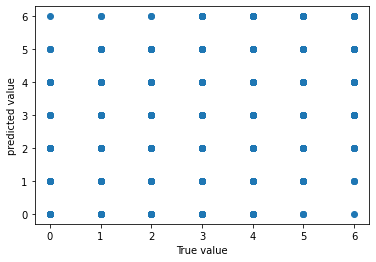

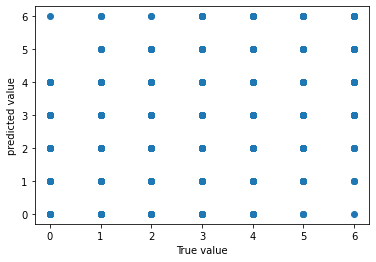

In [0]:
if args['do_train']:
  fit()

### Model Evaluation

In this part, the model will be evaluated against the `test.csv`.

In [0]:
# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels, state_dict=model_state_dict)
model.to(device)

04/19/2020 20:26:29 - INFO - pytorch_pretrained_bert.modeling -   loading archive file ../BERT/uncased_L-12_H-768_A-12 from cache at ../BERT/uncased_L-12_H-768_A-12
04/19/2020 20:26:29 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertForMultiLabelSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=

04/19/2020 20:26:31 - INFO - __main__ -   ***** Running evaluation *****
04/19/2020 20:26:31 - INFO - __main__ -     Num examples = 1939
04/19/2020 20:26:31 - INFO - __main__ -     Batch size = 10


04/19/2020 20:27:16 - INFO - __main__ -   ***** Eval results *****
04/19/2020 20:27:16 - INFO - __main__ -     R_square = 0.5444056791499606
04/19/2020 20:27:16 - INFO - __main__ -     eval_accuracy = 0.39865910263022175
04/19/2020 20:27:16 - INFO - __main__ -     eval_loss = 1.4591594614933447
04/19/2020 20:27:16 - INFO - __main__ -     mcc = 0.3014000573685409



1939 1939
[2 0 1 1 ... 3 1 4 6]
[4 0 0 2 ... 4 1 2 6]


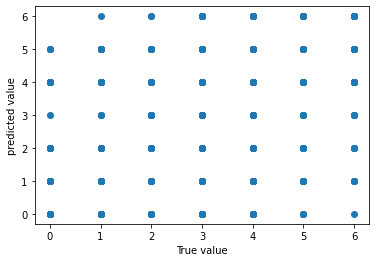

In [0]:
# run this only if you need to evalute a dataset from pre-trained model
if args['do_eval']:
  eval(eval_features)

In [0]:
# This function accpets a csv file (test.csv) with sample id place in the first column (no matter what the column name is) and the comment_text placed in the second column.
# The function will return the result as a dataframe with the id, comment_text, logits output by each node and the predicted label. 

def predict(model, path, test_filename='test.csv'):
    predict_processor = MultiLabelTextProcessor(path)
     
    test_examples = predict_processor.get_test_examples(path, test_filename, size= args['test_size'])
    
    # Hold input data for returning it 
    input_data = [{ 'id': input_example.guid, 'comment_text': input_example.text_a } for input_example in test_examples]

    test_features = convert_examples_to_features(
        test_examples, label_list, args['max_seq_length'], tokenizer)
    
    logger.info("***** Running prediction *****")
    logger.info("  Num examples = %d", len(test_examples))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    
    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)

    test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
    
    # Run prediction for full data
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=args['eval_batch_size'])
    
    all_logits = None
    all_predictions = None
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    
    for step, batch in enumerate(tqdm(test_dataloader, desc="Prediction Iteration")):
        input_ids, input_mask, segment_ids = batch
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)

        with torch.no_grad():
            logits = model(input_ids, segment_ids, input_mask)
            #logits = logits.sigmoid()
        
        logits = logits.detach().cpu().numpy()
        # convet logits to softmax in order to output probabilities
        logits = softmax(logits, axis=1)
        predictions = np.argmax(logits, axis=1) 
       
        if all_logits is None:
            all_logits = logits   
        else:
            all_logits = np.concatenate((all_logits, logits), axis=0)
            
        if all_predictions is None:
          all_predictions = predictions
        else: 
          all_predictions = np.concatenate((all_predictions, predictions), axis=0)

        df_temp = pd.merge(pd.DataFrame(input_data, columns=['id', 'comment_text']), pd.DataFrame(all_logits, columns=label_list), left_index=True, right_index=True) 
        
        df_pred = pd.merge(df_temp, pd.DataFrame(all_predictions, columns=['label']),left_index=True, right_index=True)

    return df_pred

In [0]:
if args['do_test']:
  result = predict(model, TEST_DATA_Path)

04/19/2020 20:27:17 - INFO - __main__ -   ***** Running prediction *****
04/19/2020 20:27:17 - INFO - __main__ -     Num examples = 414
04/19/2020 20:27:17 - INFO - __main__ -     Batch size = 10


In [0]:
# calculate estimated price based on the weight (the median price of bins when convert continous price values from training data to labels )
weight = [35,73,104,145,210,374.5,700] 
result['price'] = weight[0]* result[0] + weight[1]* result[1] + weight[2]* result[2] + weight[3]* result[3] + weight[4]* result[4] +  weight[5]* result[5] + weight[6]* result[6]

04/19/2020 20:27:23 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


In [0]:
result.head(10)

,id,comment_text,0,1,2,3,4,5,6,label,price
0,14259981,New Build by Stonehollow Homes. and almost com...,0.003270,0.022230,0.065811,0.100673,0.273864,0.356728,0.177423,5,338.481323
1,14259967,Beautiful Stonehollow Home on wide 1 ACRE with...,0.001011,0.003735,0.010526,0.024679,0.108137,0.364256,0.487656,6,505.462891
2,14316135,"Country Home built in 2008, nice condition, gr...",0.037847,0.092995,0.124730,0.126314,0.258740,0.245664,0.113710,4,265.334259
3,56522084,This incredible Beazer home features high ceil...,0.013259,0.123480,0.245166,0.280775,0.205466,0.100830,0.031025,3,178.313858
4,204484,3/2/2 BRICK HOME THAT WAS COMPLETLY REMODELED ...,0.003825,0.014507,0.042634,0.075660,0.263137,0.395330,0.204907,5,363.342621
5,209713,This Beautiful Custom Home is located in the f...,0.003094,0.011619,0.034338,0.059334,0.234479,0.375324,0.281813,5,400.199280
6,1449029,X-30 JASMINE PLAN- FEATURES 4 BEDRROMS 2.5 BA...,0.065468,0.171387,0.199086,0.166581,0.202727,0.140628,0.054122,4,192.785034
7,1449486,The Ingleside - 1900 Plan - Open floor plan wi...,0.005739,0.012956,0.022064,0.037699,0.131936,0.311189,0.478416,6,488.045898
8,1449533,The Garland Plan - This Cozy 3 bedroom plan co...,0.021420,0.063373,0.123252,0.140628,0.248452,0.287512,0.115362,5,279.186768
9,1449028,Located between Marbach & Potranco Rd. On 1604,0.119486,0.168259,0.162695,0.157816,0.175852,0.130324,0.085568,4,201.901566


In [0]:
#custmize the column name
result.rename(columns = {'id':'mls_id', 'comment_text':'description'}, inplace = True) 



In [0]:
# save full results that include the comment_text and logits output by each head
result.to_csv(TEST_DATA_Path/'rental_price_pred.csv', index=None)

# save a simplified result set with only id and label 
result[['mls_id','price']].to_csv(TEST_DATA_Path/'rental_price_pred_brief.csv', index=None)